In [36]:
%pip install ultralytics


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [37]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from keras.applications.resnet_v2 import preprocess_input
from keras.models import load_model
import numpy as np
import pickle
import cv2


image 1/1 /Users/ananyathapar/EE428/dog-breed-classification/dog.jpg: 480x640 1 dog, 64.0ms
Speed: 1.2ms preprocess, 64.0ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)
1/1 [==============================] - 1s 590ms/step
Predicted breed: great_pyrenees

image 1/1 /Users/ananyathapar/EE428/dog-breed-classification/dog.jpg: 480x640 1 dog, 56.5ms
Speed: 1.3ms preprocess, 56.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


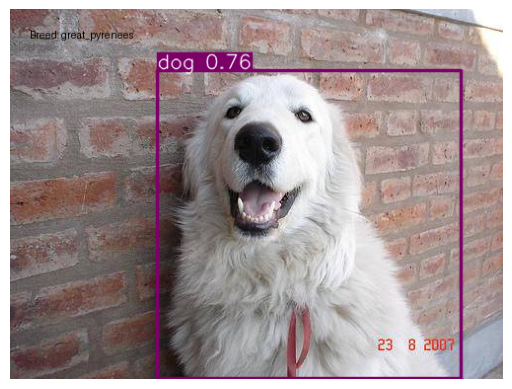

In [38]:
# paths
image_path = "dog.jpg"
model_path = "model"
encoder_path = "encoder.pkl"
yolo_weights = "yolov8n.pt"
im_size = 224

# load models 
yolo_model = YOLO(yolo_weights)
resnet_model = load_model(model_path)

with open(encoder_path, "rb") as f:
    encoder = pickle.load(f)

# crop the test image using YOLO
def crop_dog_from_image(image_path, model):
    results = model(image_path)
    detections = results[0].boxes.xyxy.cpu().numpy()
    if len(detections) == 0:
        print(f"No dog detected in {image_path}.")
        return None
    x1, y1, x2, y2 = map(int, detections[0][:4])
    image = Image.open(image_path)
    cropped = image.crop((x1, y1, x2, y2))
    return cropped

# Preprocess image for ResNet input
def prepare_image(img):
    img = img.resize((im_size, im_size))
    img_array = np.expand_dims(np.array(img).astype(np.float32), axis=0)
    return preprocess_input(img_array)

# predict breed using model
def predict_breed(image_path):
    cropped = crop_dog_from_image(image_path, yolo_model)
    if cropped is None:
        return
    processed_img = prepare_image(cropped)
    prediction = resnet_model.predict(processed_img)
    pred_label = np.argmax(prediction, axis=1)
    breed = encoder.inverse_transform(pred_label)
    print("Predicted breed:", breed[0])

    results = yolo_model(image_path)
    plot_img = results[0].plot()
    plot_img = cv2.cvtColor(plot_img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(plot_img)
    draw = ImageDraw.Draw(img)
    font = ImageFont.load_default()
    draw.text((20, 20), f"Breed: {breed[0]}", fill="black", font=font)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # save image
    output_filename = "predicted_breed.jpg"
    img.save(output_filename)

predict_breed(image_path)